In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install dcor dtaidistance

In [0]:
import os
import h5py
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import dcor
from dtaidistance import dtw

In [0]:
with h5py.File(os.path.join(root_path, 'mitdb', 'all_ecg.hdf5'), 'r') as hdf:
    x = hdf['x'][:]
    y = hdf['y'][:]

In [5]:
random.seed(2019)
x = np.array(random.choices(x, k=10000))
print(x.shape)
print(y.shape)

(10000, 1, 128)
(96049,)


In [0]:
class AvgDownSampler(nn.Module):
    def __init__(self):
        super(AvgDownSampler, self).__init__()
        self.pool = nn.AvgPool1d(4)

    def forward(self, x):
        x = self.pool(x)
        return x.data.numpy().squeeze()

In [0]:
avg_sampler = AvgDownSampler()

In [0]:
class EcgConv2(nn.Module):
    def __init__(self):
        super(EcgConv2, self).__init__()        
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 16
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        return x.data.numpy().squeeze()

In [9]:
ecg_conv2 = EcgConv2()
ecg_conv2.load_state_dict(torch.load(os.path.join(root_path, 'model', 'conv2_6_100.pth'), map_location=torch.device('cpu'))) # conv2_6_best.pth
ecg_conv2.eval()

EcgConv2(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (linear4): Linear(in_features=128, out_features=5, bias=True)
  (softmax4): Softmax(dim=1)
)

In [10]:
dtw_list = [list() for i in range(16)]
dcor_avg_sample = [list() for i in range(16)]
dcor_max_sample = [list() for i in range(16)]

for x_sample in tqdm(x):
    x_tensor = torch.tensor(np.expand_dims(x_sample, axis=0), dtype=torch.float)
    output = ecg_conv2(x_tensor)
    x_avgdown = avg_sampler(x_tensor)
    for i, o in enumerate(output):
        dtw_val = dtw.distance_fast(x_sample.squeeze().astype(np.double), o.astype(np.double))
        dtw_list[i].append(dtw_val)
        dcor_val = dcor.distance_correlation(x_avgdown, o)
        dcor_avg_sample[i].append(dcor_val)

100%|██████████| 10000/10000 [04:58<00:00, 33.46it/s]


In [11]:
np.array(dtw_list).shape

(16, 10000)

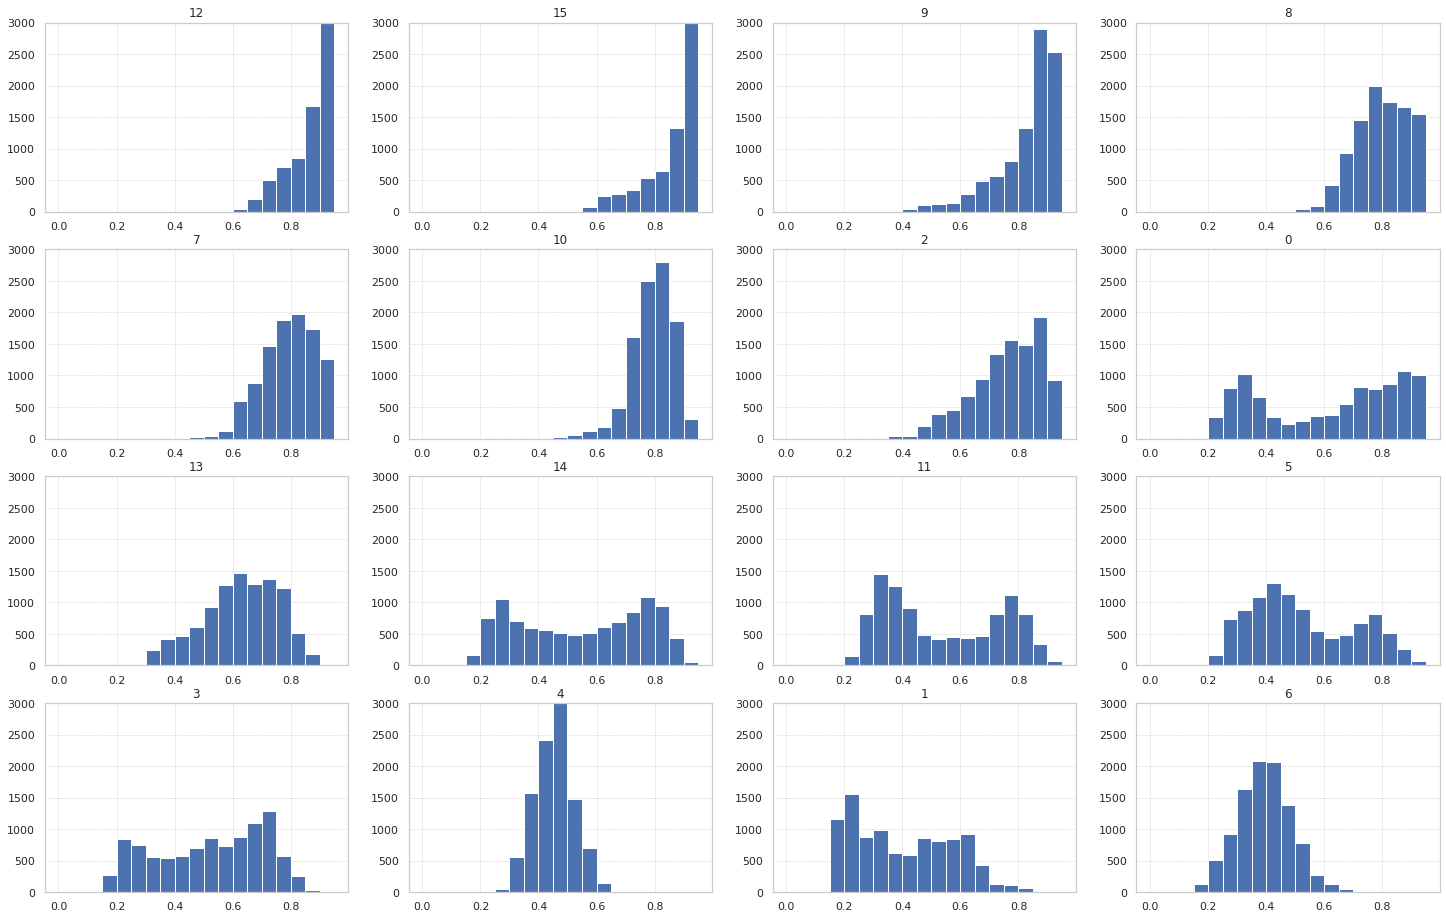

In [12]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.5, 'grid.linestyle': '--'})
dcor_avg_sample = np.array(dcor_avg_sample)
idx = np.argsort(np.mean(dcor_avg_sample, axis=1))[::-1]
dcor_avg_sample = dcor_avg_sample[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dcor_avg_sample[i], bins=[0.05 * i for i in range(20)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dcor.csv'), dcor_avg_sample, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dcor_mean.csv'), np.mean(dcor_avg_sample, axis=1), delimiter=",", fmt='%.4f')

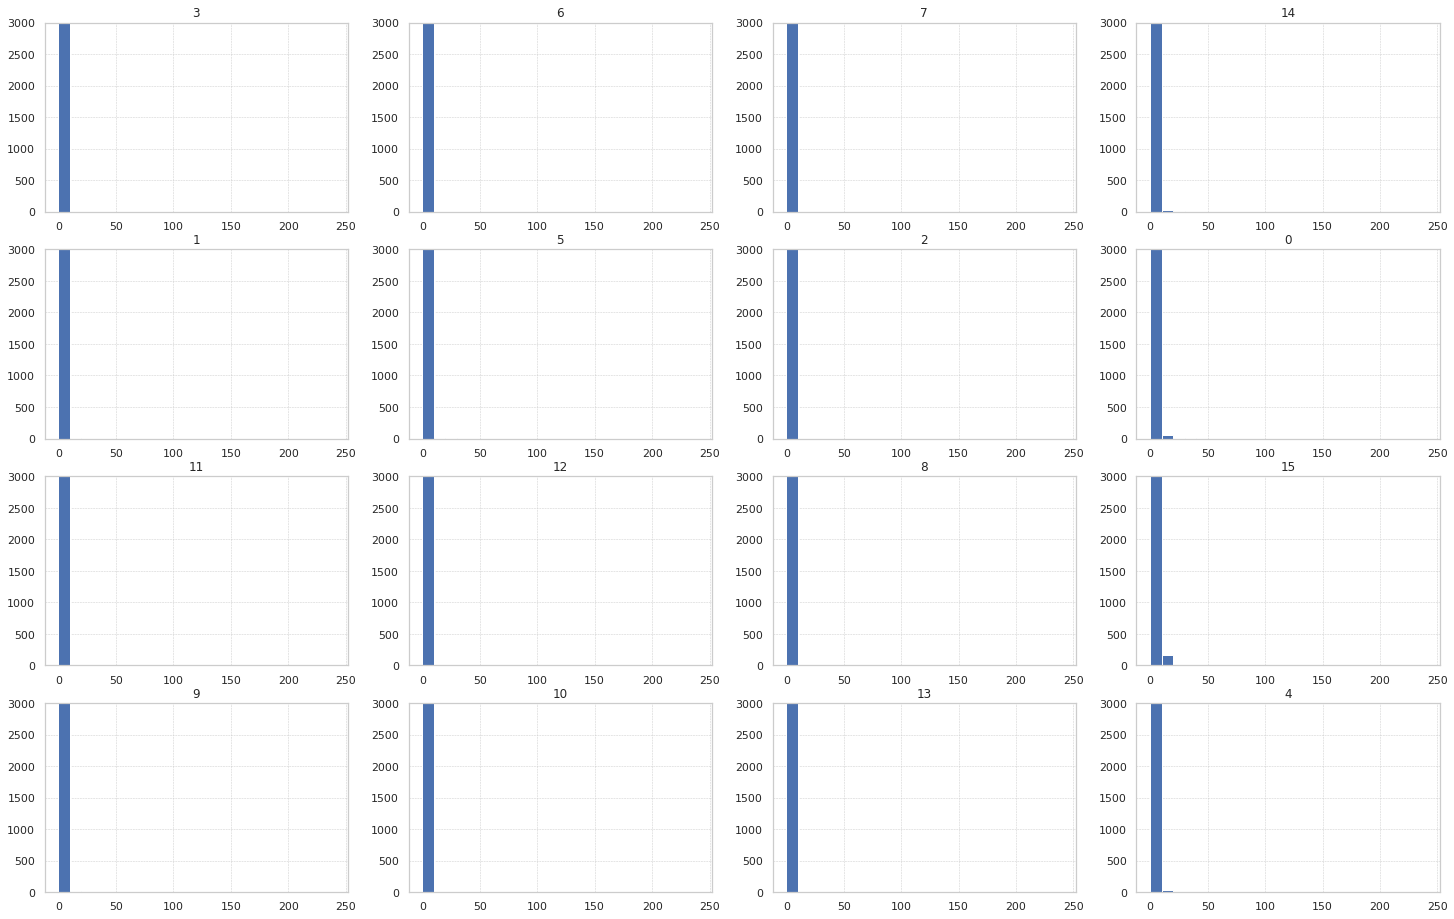

In [13]:
dtw_list = np.array(dtw_list)
idx = np.argsort(np.mean(dtw_list, axis=1))
dtw_list = dtw_list[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dtw_list[i], bins=[10 * i for i in range(25)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dtw.csv'), dtw_list, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dtw_mean.csv'), np.mean(dtw_list, axis=1), delimiter=",", fmt='%.4f')